<a href="https://colab.research.google.com/github/oxayavongsa/aai-590-capstone-mental-health/blob/main/notebook-pipeline/split_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Split Data & Encoding


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the cleaned mental health data with risk labels
#file_path = "aai-590-capstone-mental-health/data-assets/cleaned_mental_health_data.csv"
# file_path = "./data-assets/cleaned_mental_health_data.csv"
file_path = "/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/data-assets/test-mental-health.csv"
df = pd.read_csv(file_path)
df.columns

Index(['Timestamp', 'Gender', 'Country', 'Occupation', 'self_employed',
       'family_history', 'treatment', 'Days_Indoors', 'Growing_Stress',
       'Changes_Habits', 'Mental_Health_History', 'Mood_Swings',
       'Coping_Struggles', 'Work_Interest', 'Social_Weakness',
       'mental_health_interview', 'care_options'],
      dtype='object')

In [4]:
df.shape

(260986, 17)

In [5]:
# Drop the Timestamp column
df = df.drop(columns=["Timestamp"])

In [6]:
# 1. Encode all object/categorical columns first (on full DataFrame)
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le



In [7]:
# 2. Now split into train/test
X_train, X_test = train_test_split(df, test_size=0.3, random_state=42)

### Clustering

In [8]:
!pip install kmodes --quiet
from kmodes.kmodes import KModes

In [9]:
# Set the number of clusters (e.g., 3 for low/medium/high risk)
n_clusters = 3

# Fit k-modes on training data only
km = KModes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=1, random_state=42)
train_clusters = km.fit_predict(X_train)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 42039, cost: 1270222.0
Run 1, iteration: 2/100, moves: 19119, cost: 1270222.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 48434, cost: 1251299.0
Run 2, iteration: 2/100, moves: 17472, cost: 1245842.0
Run 2, iteration: 3/100, moves: 5141, cost: 1245842.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 53266, cost: 1262301.0
Run 3, iteration: 2/100, moves: 2, cost: 1262301.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 25208, cost: 1260211.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 55658, cost: 1287776.0
Best run was number 2


In [10]:
# Assign clusters to the test set using trained centroids
test_clusters = km.predict(X_test)

In [11]:
X_train['risk_label'] = train_clusters
X_test['risk_label'] = test_clusters


In [12]:
# For train data (interpretation/profiling)
for i in range(3):
    print(f"\n--- Cluster {i} (train) ---")
    display(X_train[X_train['risk_label'] == i].mode().iloc[0])


--- Cluster 0 (train) ---


,0
Gender,1
Country,9
Occupation,2
self_employed,0
family_history,0
treatment,0
Days_Indoors,2
Growing_Stress,1
Changes_Habits,2
Mental_Health_History,2



--- Cluster 1 (train) ---


,0
Gender,1
Country,9
Occupation,4
self_employed,0
family_history,1
treatment,1
Days_Indoors,2
Growing_Stress,2
Changes_Habits,0
Mental_Health_History,1



--- Cluster 2 (train) ---


,0
Gender,1
Country,9
Occupation,1
self_employed,0
family_history,0
treatment,0
Days_Indoors,0
Growing_Stress,0
Changes_Habits,2
Mental_Health_History,1


## Cluster Interpretations and Risk Labels (Based on Modal Values)

#### **Cluster 1 — High Risk**
This group exhibits the highest frequency of risk indicators, such as family history of mental health issues, prior treatment, high stress, mood swings, coping struggles, and social weakness. The concentration of "yes" responses across these features points to a high-risk profile.

#### **Cluster 0 — Medium Risk**
Individuals in this cluster show a moderate pattern: some evidence of mental health risk (e.g., mental health history, mood swings), but generally lower on coping struggles and social weakness compared to the high-risk cluster.

#### **Cluster 2 — Low Risk**
This cluster is characterized by the lowest occurrence of risk factors—most members have not sought treatment, lack a family history of mental illness, and do not report major struggles, aside from occasional mood swings or social weakness. Overall, this cluster represents the lowest mental health risk.


In [13]:
# Display the first few rows of the encoded X_train DataFrame
pd.set_option('display.max_columns', None)  # Show all columns
X_train.head()

,Gender,Country,Occupation,self_employed,family_history,treatment,Days_Indoors,Growing_Stress,Changes_Habits,Mental_Health_History,Mood_Swings,Coping_Struggles,Work_Interest,Social_Weakness,mental_health_interview,care_options,risk_label
49716,0,9,2,0,0,1,3,0,2,1,2,0,1,1,1,1,2
238330,1,9,0,0,1,1,1,1,1,2,2,0,0,2,0,2,0
237747,1,8,1,0,0,0,1,2,0,2,2,0,0,0,0,0,0
128998,1,9,2,0,0,0,1,2,0,2,2,0,0,1,0,1,0
85957,1,9,3,0,0,0,2,1,2,2,2,0,1,1,1,1,0


In [28]:
# Assume you have X_train and cluster assignments as 'risk_label'
modal_table = pd.DataFrame([
    X_train[X_train['risk_label'] == i].mode().iloc[0]
    for i in sorted(X_train['risk_label'].unique())
])

# Drop the cluster label column
modal_table = modal_table.drop(columns=['risk_label'])

# Compute variance for each feature's mode across clusters
modal_variances = modal_table.var()

# Sort features by variance (descending)
defining_features = modal_variances.sort_values(ascending=False)
print(defining_features)


Occupation                 2.333333
Days_Indoors               1.333333
care_options               1.333333
Changes_Habits             1.333333
Social_Weakness            1.000000
Work_Interest              1.000000
Growing_Stress             1.000000
treatment                  0.333333
Mood_Swings                0.333333
Coping_Struggles           0.333333
family_history             0.333333
Mental_Health_History      0.333333
Country                    0.000000
Gender                     0.000000
self_employed              0.000000
mental_health_interview    0.000000
dtype: float64


> We excluded the five most cluster-defining features—**Occupation**, **Days_Indoors**, **care_options**, **Changes_Habits**, and **Social_Weakness**—from our predictive modeling. All five features reflect aspects of an individual’s social environment and lifestyle stability, which are critical drivers of mental health risk. Their removal allows us to test whether meaningful risk prediction is possible in scenarios where key social and lifestyle data is unavailable or incomplete, such as in remote assessments or datasets with privacy restrictions.


### EDA for Risk
This is to understand the impact risk label has and how it looks within the training data.

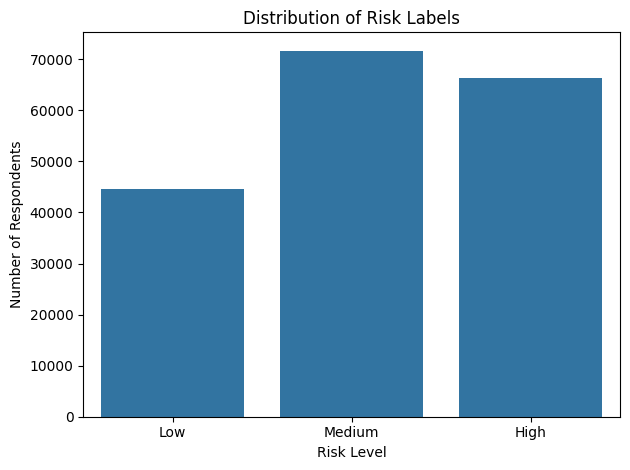

In [29]:
# Correct mapping based on your cluster interpretation
risk_label_map = {1: "High", 0: "Medium", 2: "Low"}

df_filtered = X_train.copy()
df_filtered['risk_label'] = df_filtered['risk_label'].map(risk_label_map)

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='risk_label', data=df_filtered, order=["Low", "Medium", "High"])
plt.title("Distribution of Risk Labels")
plt.xlabel("Risk Level")
plt.ylabel("Number of Respondents")
plt.tight_layout()
plt.show()


                    Feature          Chi2
3            family_history  18174.578898
4                 treatment  15931.627449
5            Growing_Stress   7592.649360
8          Coping_Struggles   7491.387275
9             Work_Interest   7107.476509
6     Mental_Health_History   3644.431247
7               Mood_Swings   2639.510395
0                    Gender    907.624720
10  mental_health_interview     46.719225
2             self_employed     40.814096
1                   Country     18.492166


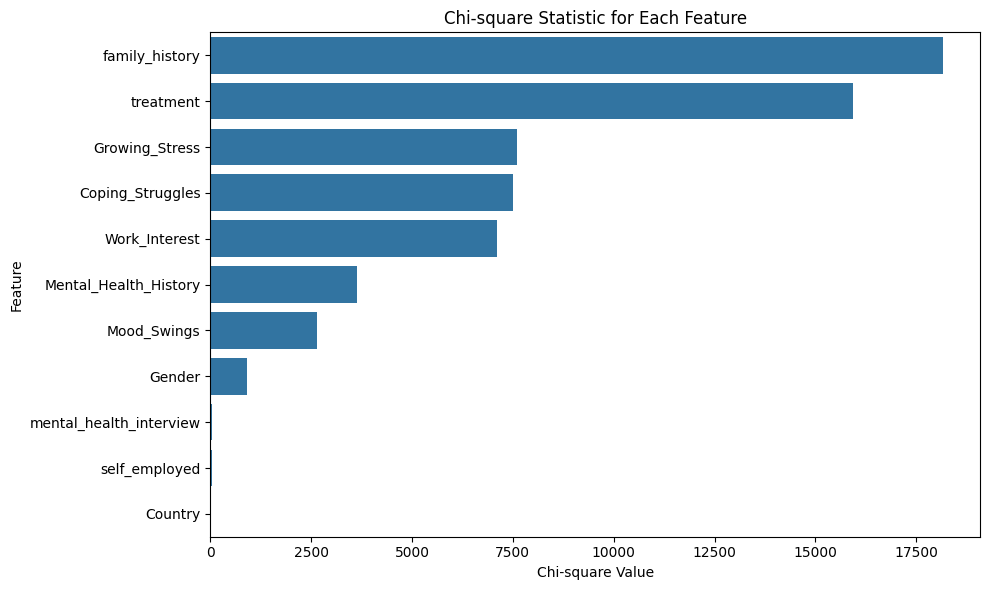

In [30]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Use the filtered list of categorical features (excludes features previously removed)
cat_features = [
    'Gender',
    'Country',
    'self_employed',
    'family_history',
    'treatment',
    'Growing_Stress',
    'Mental_Health_History',
    'Mood_Swings',
    'Coping_Struggles',
    'Work_Interest',
    'mental_health_interview'
]

# Encode categorical features for Chi-square
X = df_filtered[cat_features].apply(LabelEncoder().fit_transform)
# Encode risk_label as numeric
y = LabelEncoder().fit_transform(df_filtered['risk_label'])

# Chi-square feature selection
chi_scores = chi2(X, y)
chi_df = pd.DataFrame({'Feature': cat_features, 'Chi2': chi_scores[0]})
chi_df = chi_df.sort_values('Chi2', ascending=False)
print(chi_df)

# (Optional) Visualize the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Chi2', y='Feature', data=chi_df)
plt.title("Chi-square Statistic for Each Feature")
plt.xlabel("Chi-square Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


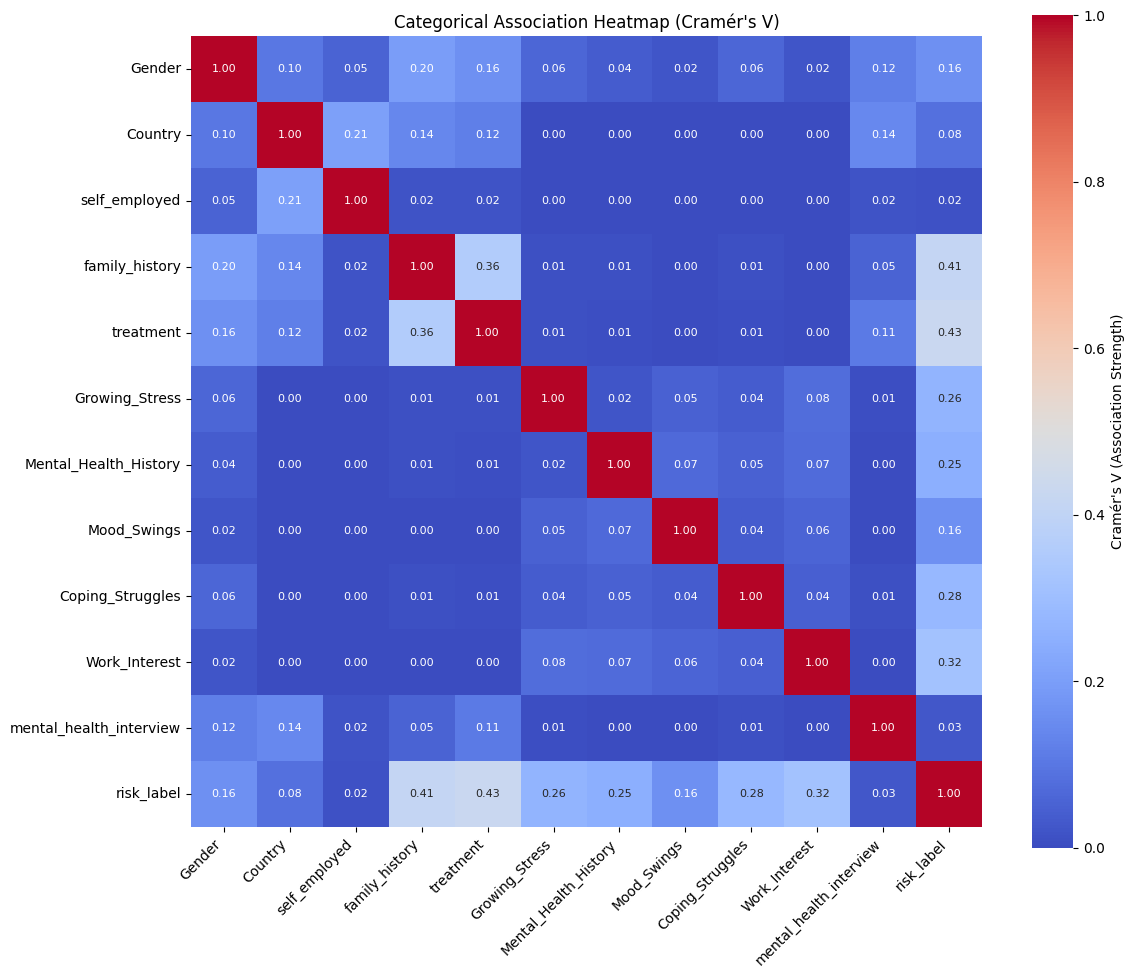

In [31]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns


# Add risk_label if not in the list
if 'risk_label' not in cat_features:
    cat_features.append('risk_label')

# Make sure all columns are of 'category' dtype for the Cramér's V function
for col in cat_features:
    if col in df_filtered.columns:
        df_filtered[col] = df_filtered[col].astype('category')

# Define Cramér’s V function with bias correction
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix, correction=False)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Initialize an association matrix
assoc_matrix = pd.DataFrame(np.eye(len(cat_features)), index=cat_features, columns=cat_features)

# Fill the upper triangle of the matrix with Cramér’s V values
for i, col1 in enumerate(cat_features):
    for j, col2 in enumerate(cat_features):
        if i < j:
            value = cramers_v(df_filtered[col1], df_filtered[col2])
            assoc_matrix.loc[col1, col2] = value
            assoc_matrix.loc[col2, col1] = value

assoc_matrix = assoc_matrix.astype(float)

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    assoc_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
    annot_kws={"size": 8}, cbar_kws={'label': "Cramér's V (Association Strength)"}
)
plt.title("Categorical Association Heatmap (Cramér's V)")
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10, rotation=0)
plt.tight_layout()
plt.show()


In [32]:
# Define y (cluster assignments as your label)
y_train = X_train['risk_label']
y_test = X_test['risk_label']

# Define X (all features except risk_label AND the five most influential features)
features_to_remove = [
    'risk_label',       # Always drop the label from features
    'Occupation',
    'Days_Indoors',
    'care_options',
    'Changes_Habits',
    'Social_Weakness'
]

X_train_model = X_train.drop(columns=features_to_remove)
X_test_model = X_test.drop(columns=features_to_remove)

# (Optional) Check columns
print("Columns in X_train_model:", X_train_model.columns.tolist())



Columns in X_train_model: ['Gender', 'Country', 'self_employed', 'family_history', 'treatment', 'Growing_Stress', 'Mental_Health_History', 'Mood_Swings', 'Coping_Struggles', 'Work_Interest', 'mental_health_interview']


### Scaling

In [33]:
from sklearn.preprocessing import StandardScaler

# Fit scaler on training data, then transform both train and test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_model)
X_test_scaled = scaler.transform(X_test_model)

# If you want to keep it as a DataFrame with column names:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_model.columns, index=X_train_model.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_model.columns, index=X_test_model.index)


print("Scaling and normalization completed.")

Scaling and normalization completed.


In [34]:
directory = "/content/drive/MyDrive/Colab Notebooks/AAI-590/final/aai-590-capstone-mental-health/data-assets/"

X_train_scaled.to_csv(f"{directory}test_X_train_encoded_scaled.csv", index=False)
X_test_scaled.to_csv(f"{directory}test_X_test_encoded_scaled.csv", index=False)
pd.DataFrame(y_train).to_csv(f"{directory}test_y_train.csv", index=False)
pd.DataFrame(y_test).to_csv(f"{directory}test_y_test.csv", index=False)


In [35]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (182690, 17)
X_test shape: (78296, 17)
y_train shape: (182690,)
y_test shape: (78296,)
